In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import joblib
import shap

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
shap.initjs()

In [2]:
# Load best tuned model
models_path = Path("../models")
model = joblib.load(models_path / "tuned_model.pkl")
print(f"Loaded model: {type(model).__name__}")

# Check if processed data splits exist, if not create them
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

processed_path = Path("../data/processed")
processed_path.mkdir(parents=True, exist_ok=True)

train_file = processed_path / "train.csv"
val_file = processed_path / "val.csv"
test_file = processed_path / "test.csv"

if not all([train_file.exists(), val_file.exists(), test_file.exists()]):
    print("Creating train/val/test splits...")
    
    # Load feature-engineered data
    df = pd.read_csv(Path("../data/features/data_with_features.csv"))
    print(f"Loaded data shape: {df.shape}")
    
    # Separate target
    y = df['Churn']
    X = df.drop('Churn', axis=1)
    
    # Identify categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    # Encode categorical variables 
    X_encoded = X.copy()
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print("Categorical variables encoded")
    
    # Split data
    # First: train+val vs test (80/20)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_encoded, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    # Second: train vs val (75/25 of remaining)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=0.25,
        random_state=42,
        stratify=y_temp
    )
    
    # Combine features and target for saving
    train_df = X_train.copy()
    train_df['Churn'] = y_train
    
    val_df = X_val.copy()
    val_df['Churn'] = y_val
    
    test_df = X_test.copy()
    test_df['Churn'] = y_test
    
    # Save splits
    train_df.to_csv(train_file, index=False)
    val_df.to_csv(val_file, index=False)
    test_df.to_csv(test_file, index=False)
    
    print(f"Saved splits to {processed_path}")
    print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
else:
    print("Loading existing train/val/test splits...")

# Load data
train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)

X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']

X_test = test_df.drop('Churn', axis=1)
y_test = test_df['Churn']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Loaded model: LGBMClassifier
Loading existing train/val/test splits...
Train shape: (4225, 32)
Test shape: (1409, 32)


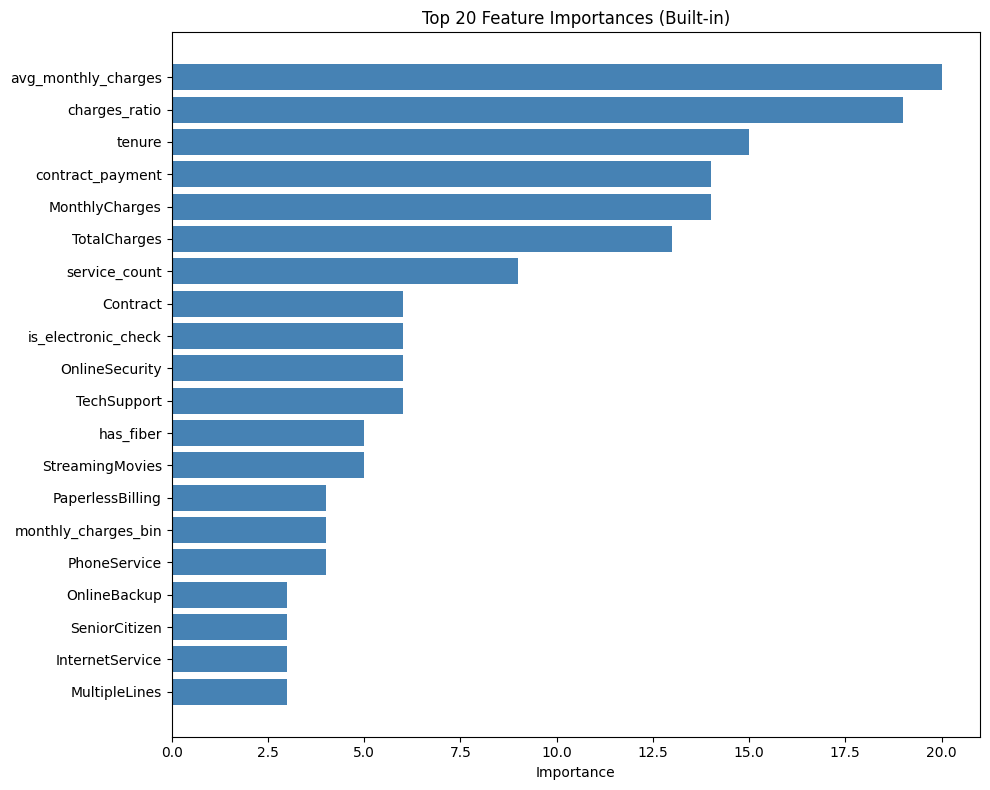

Top 10 Features:
                feature  importance
21  avg_monthly_charges          20
22        charges_ratio          19
4                tenure          15
24     contract_payment          14
17       MonthlyCharges          14
18         TotalCharges          13
23        service_count           9
14             Contract           6
29  is_electronic_check           6
8        OnlineSecurity           6


In [3]:
# Get feature importance from model
if hasattr(model, 'feature_importances_'):
    importance = model.feature_importances_
elif hasattr(model, 'get_feature_importance'):
    importance = model.get_feature_importance()
else:
    importance = None

if importance is not None:
    # Create dataframe
    feat_imp_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    }).sort_values('importance', ascending=False).head(20)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feat_imp_df)), feat_imp_df['importance'], color='steelblue')
    plt.yticks(range(len(feat_imp_df)), feat_imp_df['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances (Built-in)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Features:")
    print(feat_imp_df.head(10))
else:
    print("Model doesn't have built-in feature importance")

In [4]:
# Sample data for explanation (use subset for speed)
X_sample = X_test.sample(min(1000, len(X_test)), random_state=42)

# Create SHAP explainer
if hasattr(model, 'predict_proba'):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, get positive class SHAP values
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Positive class (Churn=1)
else:
    explainer = shap.Explainer(model)
    shap_values = explainer(X_sample)

print(f"SHAP values shape: {shap_values.shape}")

SHAP values shape: (1000, 32)


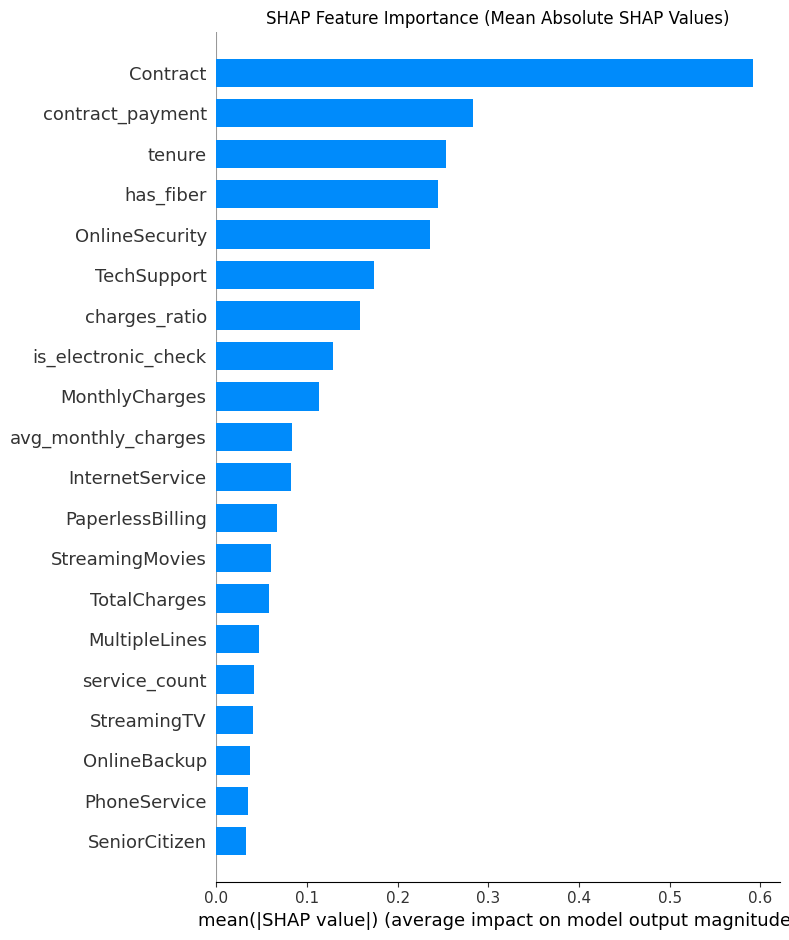

In [5]:
# Summary plot (bar)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Values)')
plt.tight_layout()
plt.show()

Top 4 features: ['Contract', 'contract_payment', 'tenure', 'has_fiber']


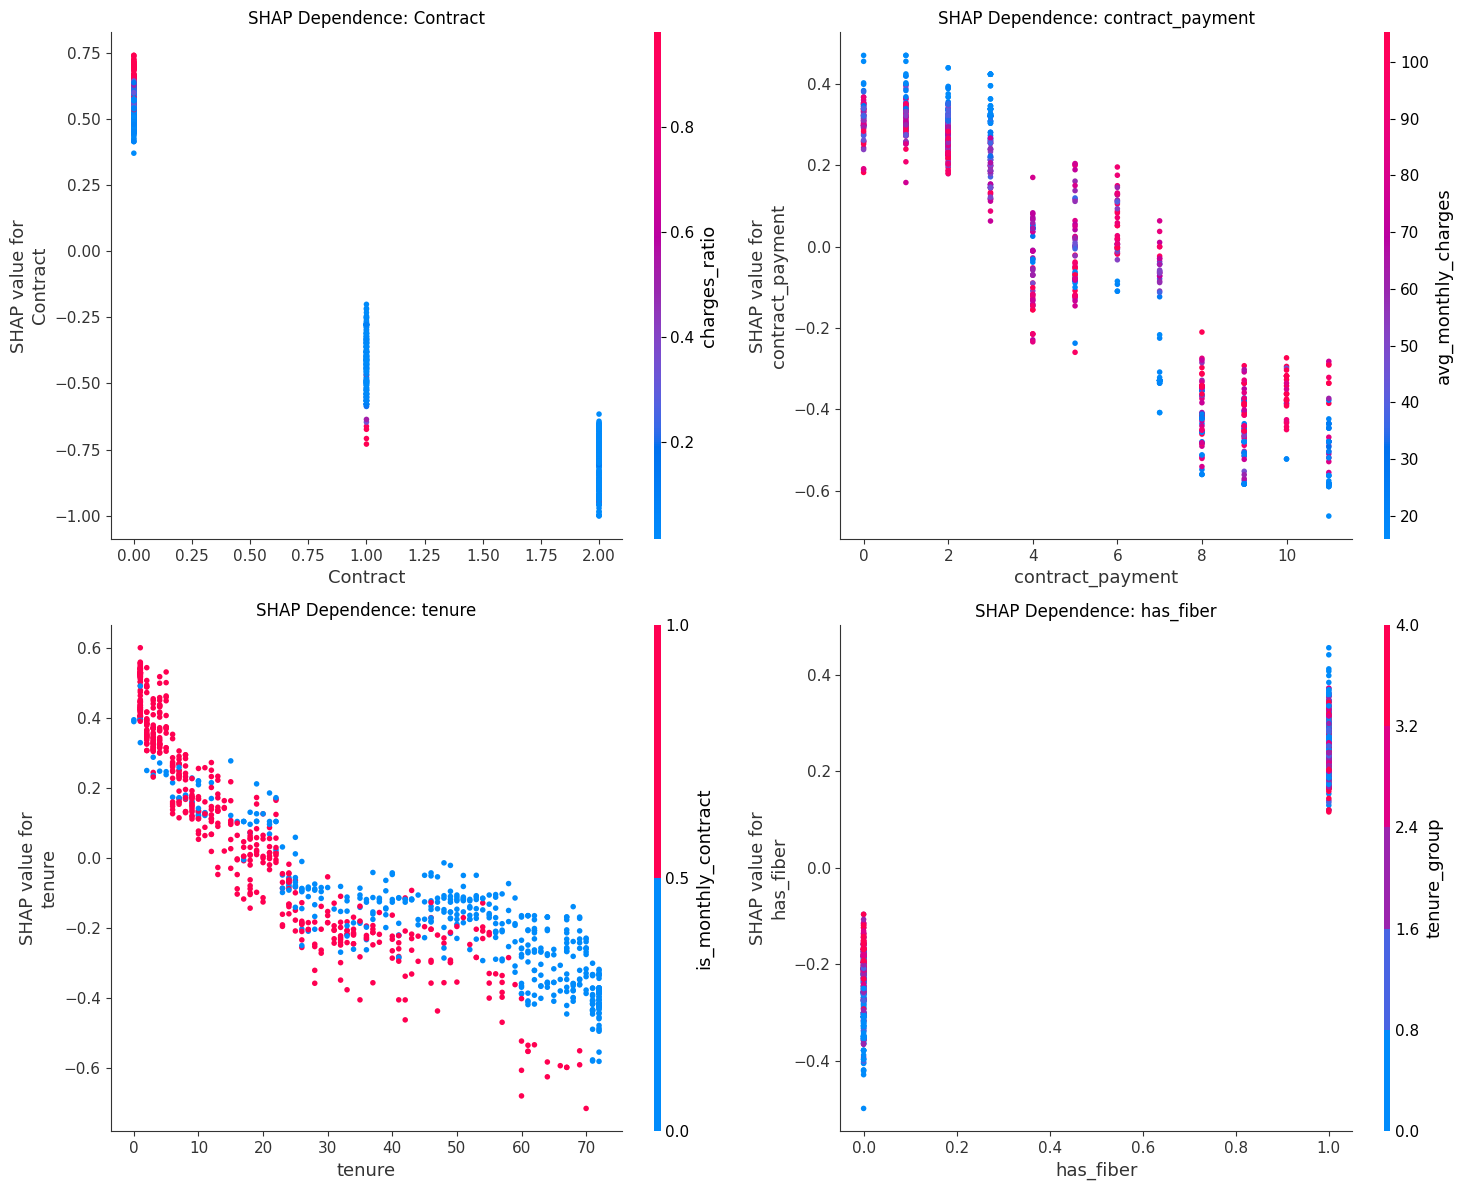


Interpretation:
- Shows how feature values affect predictions
- Vertical spread = interaction with other features
- Color = interaction with most correlated feature



In [6]:
# Get top 4 features
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap)[-4:][::-1]
top_features = X_sample.columns[top_features_idx]

print(f"Top 4 features: {list(top_features)}")

# Create dependence plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_sample,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}')

plt.tight_layout()
plt.show()

print("""
Interpretation:
- Shows how feature values affect predictions
- Vertical spread = interaction with other features
- Color = interaction with most correlated feature
""")

Explaining prediction for a customer who CHURNED:
True label: Churned
Predicted probability: 0.782


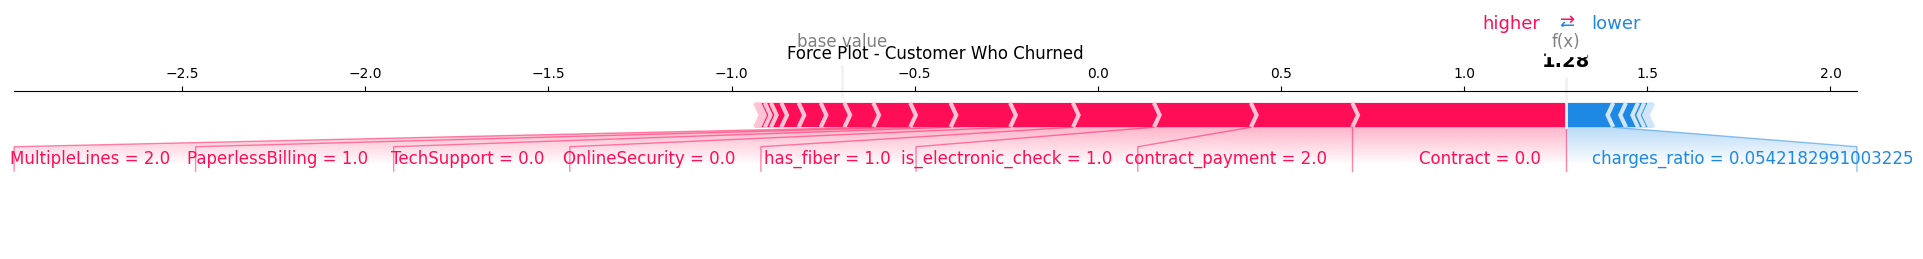


Top features pushing towards CHURN (positive SHAP):
                feature  shap_value  feature_value
14             Contract    0.583612         0.0000
24     contract_payment    0.276868         2.0000
29  is_electronic_check    0.264665         1.0000
27            has_fiber    0.221219         1.0000
8        OnlineSecurity    0.171470         0.0000
11          TechSupport    0.162532         0.0000
15     PaperlessBilling    0.110228         1.0000
6         MultipleLines    0.100647         2.0000
21  avg_monthly_charges    0.078921        73.5875
1         SeniorCitizen    0.064735         1.0000


In [7]:
# Select a customer who churned
churned_idx = X_sample[y_test[X_sample.index] == 1].index[0]
churned_customer = X_sample.loc[churned_idx]

print("Explaining prediction for a customer who CHURNED:")
print(f"True label: Churned")
print(f"Predicted probability: {model.predict_proba([churned_customer])[0][1]:.3f}")

# Force plot
shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values[X_sample.index.get_loc(churned_idx)],
    churned_customer,
    matplotlib=True,
    show=False
)
plt.title("Force Plot - Customer Who Churned")
plt.tight_layout()
plt.show()

print("\nTop features pushing towards CHURN (positive SHAP):")
shap_churned = shap_values[X_sample.index.get_loc(churned_idx)]
feature_shap = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_value': shap_churned,
    'feature_value': churned_customer.values
}).sort_values('shap_value', ascending=False)
print(feature_shap.head(10))

Explaining prediction for a customer who STAYED:
True label: Retained
Predicted probability: 0.393


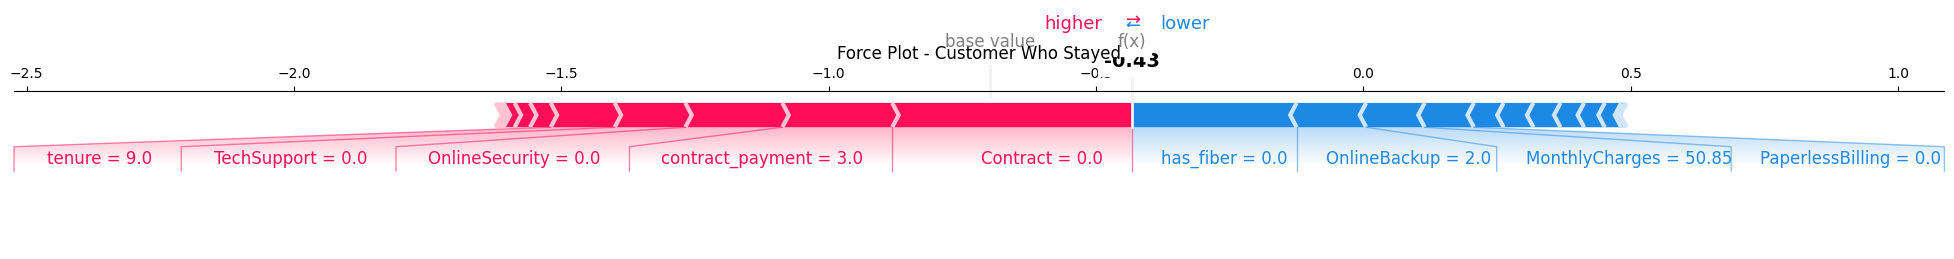


Top features pushing towards RETENTION (negative SHAP):
                feature  shap_value  feature_value
27            has_fiber   -0.308595           0.00
9          OnlineBackup   -0.130035           2.00
17       MonthlyCharges   -0.109471          50.85
15     PaperlessBilling   -0.092011           0.00
29  is_electronic_check   -0.055660           0.00
5          PhoneService   -0.055655           1.00
12          StreamingTV   -0.050647           0.00
20  monthly_charges_bin   -0.044185           2.00
6         MultipleLines   -0.038721           0.00
13      StreamingMovies   -0.030714           0.00


In [8]:
# Select a customer who didn't churn
retained_idx = X_sample[y_test[X_sample.index] == 0].index[0]
retained_customer = X_sample.loc[retained_idx]

print("Explaining prediction for a customer who STAYED:")
print(f"True label: Retained")
print(f"Predicted probability: {model.predict_proba([retained_customer])[0][1]:.3f}")

# Force plot
shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values[X_sample.index.get_loc(retained_idx)],
    retained_customer,
    matplotlib=True,
    show=False
)
plt.title("Force Plot - Customer Who Stayed")
plt.tight_layout()
plt.show()

print("\nTop features pushing towards RETENTION (negative SHAP):")
shap_retained = shap_values[X_sample.index.get_loc(retained_idx)]
feature_shap = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_value': shap_retained,
    'feature_value': retained_customer.values
}).sort_values('shap_value', ascending=True)
print(feature_shap.head(10))

Waterfall plot - shows step-by-step contribution to prediction


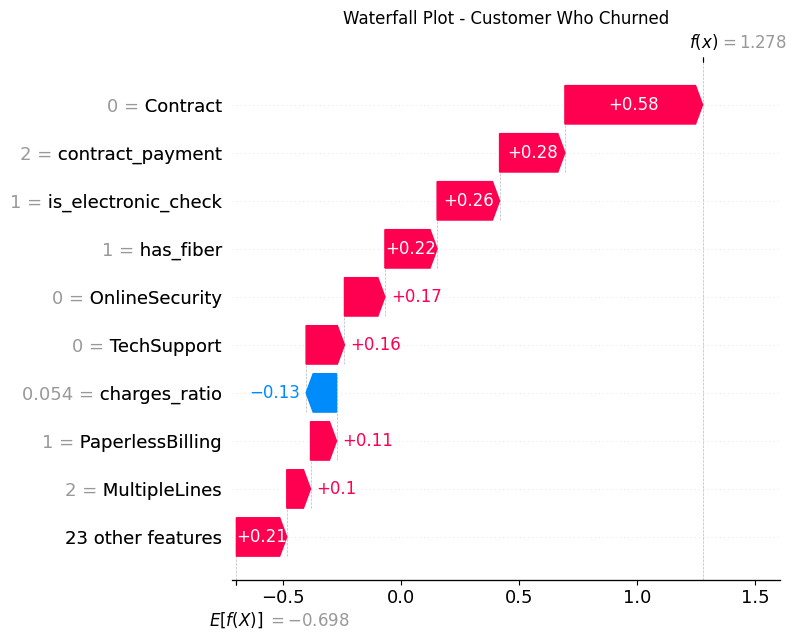

In [9]:
# Waterfall plot for churned customer
print("Waterfall plot - shows step-by-step contribution to prediction")

# For newer SHAP versions
if hasattr(shap, 'Explanation'):
    # Create Explanation object
    explanation = shap.Explanation(
        values=shap_values[X_sample.index.get_loc(churned_idx)],
        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        data=churned_customer.values,
        feature_names=X_sample.columns.tolist()
    )
    
    shap.waterfall_plot(explanation, show=False)
    plt.title("Waterfall Plot - Customer Who Churned")
    plt.tight_layout()
    plt.show()
else:
    print("Waterfall plot requires SHAP >= 0.40.0")

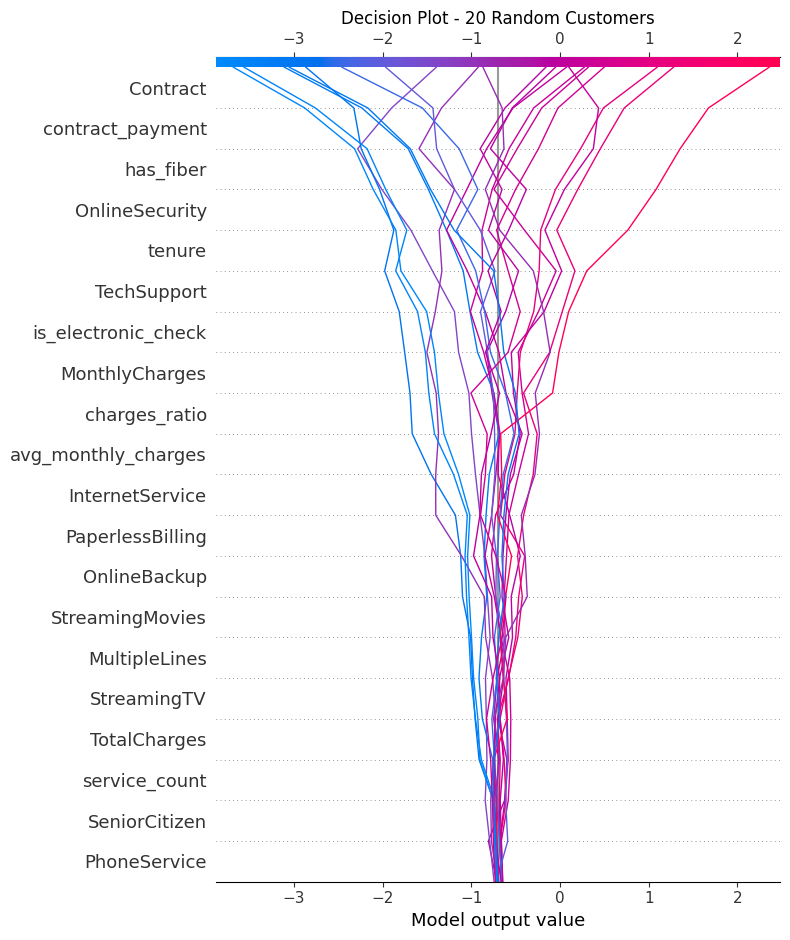


Interpretation:
- Each line represents one customer's prediction path
- Starting from baseline (left), features accumulate
- Final position = predicted probability
- Features ordered by average importance



In [10]:
# Decision plot - shows how features accumulate to final prediction

# Select 20 random samples
sample_indices = np.random.choice(len(X_sample), 20, replace=False)

plt.figure(figsize=(12, 8))
shap.decision_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values[sample_indices],
    X_sample.iloc[sample_indices],
    show=False
)
plt.title("Decision Plot - 20 Random Customers")
plt.tight_layout()
plt.show()

print("""
Interpretation:
- Each line represents one customer's prediction path
- Starting from baseline (left), features accumulate
- Final position = predicted probability
- Features ordered by average importance
""")

Analyzing feature interactions...

Interaction between: Contract and contract_payment


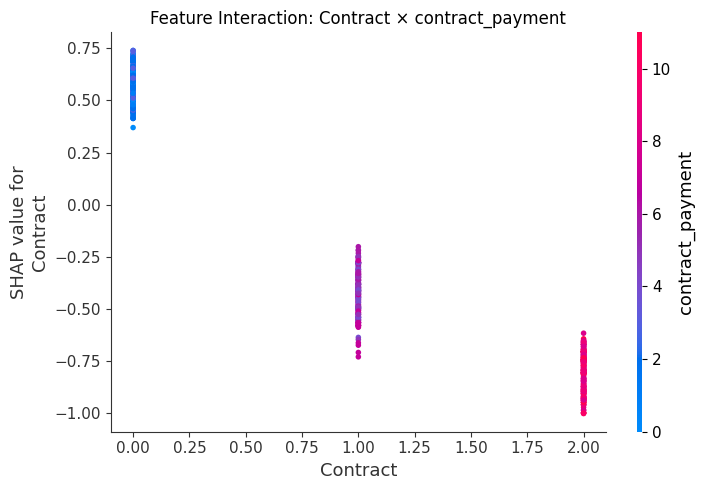

In [11]:
# Analyze feature interactions
print("Analyzing feature interactions...")

# Get top 2 features
top_2_features = X_sample.columns[top_features_idx[:2]]

print(f"\nInteraction between: {top_2_features[0]} and {top_2_features[1]}")

# Interaction plot
shap.dependence_plot(
    top_2_features[0],
    shap_values,
    X_sample,
    interaction_index=top_2_features[1],
    show=False
)
plt.title(f'Feature Interaction: {top_2_features[0]} × {top_2_features[1]}')
plt.tight_layout()
plt.show()

In [12]:
# Get mean absolute SHAP values
mean_abs_shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 10 Most Important Features for Churn Prediction:")
print(mean_abs_shap_df.head(10))

# Analyze direction of impact
for feature in mean_abs_shap_df.head(5)['feature']:
    mean_shap = shap_values[:, X_sample.columns.get_loc(feature)].mean()
    direction = "INCREASES" if mean_shap > 0 else "DECREASES"
    
    print(f"\n{feature}:")
    print(f"  Average SHAP: {mean_shap:.4f}")
    print(f"  Impact: {direction} churn probability on average")
    
    # Correlate with actual feature values
    high_value_mask = X_sample[feature] > X_sample[feature].median()
    high_value_shap = shap_values[high_value_mask, X_sample.columns.get_loc(feature)].mean()
    low_value_shap = shap_values[~high_value_mask, X_sample.columns.get_loc(feature)].mean()
    
    print(f"  High {feature} → SHAP: {high_value_shap:.4f}")
    print(f"  Low {feature} → SHAP: {low_value_shap:.4f}")


Top 10 Most Important Features for Churn Prediction:
                feature  mean_abs_shap
14             Contract       0.592044
24     contract_payment       0.283424
4                tenure       0.253559
27            has_fiber       0.244147
8        OnlineSecurity       0.235443
11          TechSupport       0.173702
22        charges_ratio       0.157972
29  is_electronic_check       0.128278
17       MonthlyCharges       0.112786
21  avg_monthly_charges       0.082770

Contract:
  Average SHAP: 0.0422
  Impact: INCREASES churn probability on average
  High Contract → SHAP: -0.6192
  Low Contract → SHAP: 0.5704

contract_payment:
  Average SHAP: 0.0455
  Impact: INCREASES churn probability on average
  High contract_payment → SHAP: -0.2554
  Low contract_payment → SHAP: 0.2857

tenure:
  Average SHAP: -0.0230
  Impact: DECREASES churn probability on average
  High tenure → SHAP: -0.2596
  Low tenure → SHAP: 0.2118

has_fiber:
  Average SHAP: -0.0216
  Impact: DECREASES churn p

In [13]:
recommendations = []

# Analyze top features
for idx, row in mean_abs_shap_df.head(10).iterrows():
    feature = row['feature']
    mean_shap = shap_values[:, X_sample.columns.get_loc(feature)].mean()
    
    # Determine if high or low values increase churn
    high_value_mask = X_sample[feature] > X_sample[feature].median()
    high_churn_rate = y_test[X_sample[high_value_mask].index].mean()
    low_churn_rate = y_test[X_sample[~high_value_mask].index].mean()
    
    if high_churn_rate > low_churn_rate:
        risk_level = "HIGH"
        action = f"Target customers with high {feature}"
    else:
        risk_level = "LOW"
        action = f"Encourage higher {feature}"
    
    recommendations.append({
        'feature': feature,
        'risk_level': risk_level,
        'high_value_churn': f"{high_churn_rate:.2%}",
        'low_value_churn': f"{low_churn_rate:.2%}",
        'action': action
    })

rec_df = pd.DataFrame(recommendations)
print(rec_df.to_string(index=False))

            feature risk_level high_value_churn low_value_churn                                         action
           Contract        LOW            6.98%          43.53%                      Encourage higher Contract
   contract_payment        LOW            6.98%          43.53%              Encourage higher contract_payment
             tenure        LOW           13.65%          40.84%                        Encourage higher tenure
          has_fiber       HIGH           42.37%          15.51%           Target customers with high has_fiber
     OnlineSecurity        LOW           12.27%          41.23%                Encourage higher OnlineSecurity
        TechSupport        LOW           11.76%          42.41%                   Encourage higher TechSupport
      charges_ratio       HIGH           41.00%          13.60%       Target customers with high charges_ratio
is_electronic_check       HIGH           43.55%          18.59% Target customers with high is_electronic_check
 

In [14]:
# Save SHAP values for future use
import pickle

shap_output_path = Path("../models/shap_values.pkl")
with open(shap_output_path, 'wb') as f:
    pickle.dump({
        'shap_values': shap_values,
        'X_sample': X_sample,
        'explainer': explainer,
        'feature_names': X_sample.columns.tolist()
    }, f)

In [15]:
# Risk Scoring Implementation
# Import risk scoring module
import sys
sys.path.append('..')
from src.models.risk_scoring import RiskScorer, create_risk_scorer

# Initialize risk scorer
risk_scorer = create_risk_scorer()

print("✅ Risk Scorer initialized successfully!")
print(f"Model loaded from: {risk_scorer.model_path}")
print(f"\nRisk Level Thresholds:")
for level, (min_score, max_score) in risk_scorer.RISK_THRESHOLDS.items():
    print(f"  {level}: {min_score}-{max_score}")



✅ Risk Scorer initialized successfully!
Model loaded from: /Users/anojanyogenthiran/Projects/churn-prediction/models/tuned_model.pkl

Risk Level Thresholds:
  LOW: 0-39
  MEDIUM: 40-69
  HIGH: 70-100


In [16]:
# Calculate risk scores for test customers
print("Calculating risk scores for test customers...\n")

# Use a sample of test data
test_sample = X_test.sample(min(100, len(X_test)), random_state=42)

# Calculate risk scores
risk_results = risk_scorer.predict_risk_batch(test_sample, return_details=True)

# Display results
print("Sample Risk Score Results:")
print(risk_results.head(10).to_string())
print(f"\nTotal customers analyzed: {len(risk_results)}")



Calculating risk scores for test customers...

Sample Risk Score Results:
   churn_probability  risk_score risk_level risk_category                             recommendation priority intervention_timing
0           0.393324          39        LOW      Low Risk             Maintain current service level      Low    Monthly check-in
1           0.569308          57     MEDIUM   Medium Risk            Engage with retention campaigns   Medium   Weekly engagement
2           0.030347           3        LOW      Low Risk             Maintain current service level      Low    Monthly check-in
3           0.782146          78       HIGH     High Risk  Immediate retention intervention required     High  Within 24-48 hours
4           0.077482           8        LOW      Low Risk             Maintain current service level      Low    Monthly check-in
5           0.022244           2        LOW      Low Risk             Maintain current service level      Low    Monthly check-in
6           0.17

Risk Level Distribution:

            count  percentage   mean  min  max    std
risk_level                                           
HIGH           24        24.0  78.46   70   92   6.66
LOW            52        52.0  15.65    2   39  11.77
MEDIUM         24        24.0  55.88   40   68  10.08


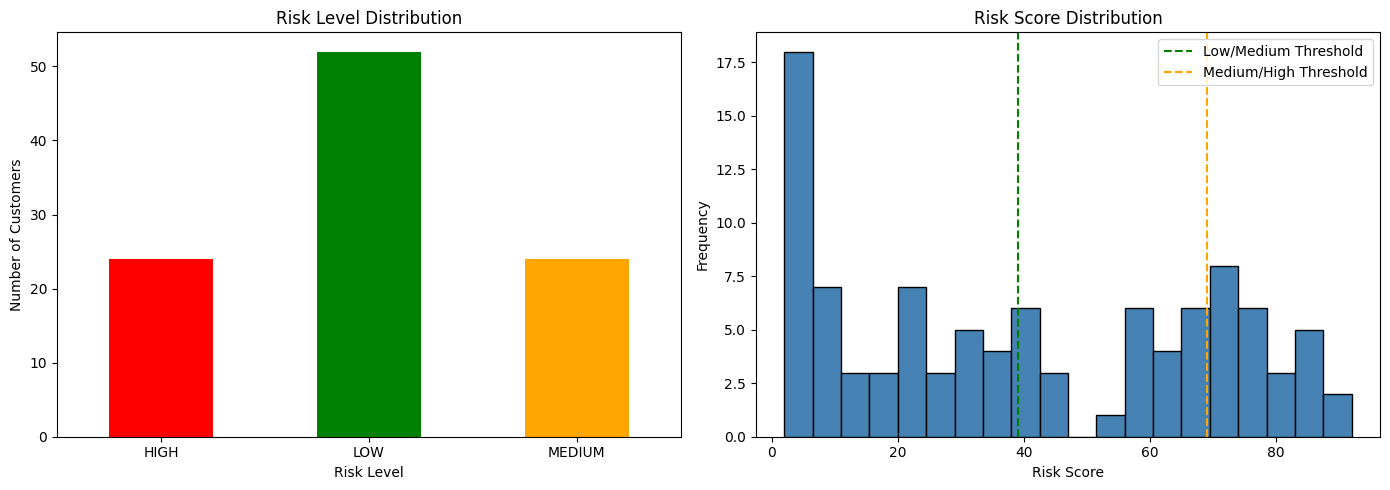

In [17]:
# Risk Distribution Analysis
print("Risk Level Distribution:\n")

distribution = risk_scorer.get_risk_distribution(test_sample)
print(distribution.to_string())

# Visualize risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk level counts
risk_counts = risk_results['risk_level'].value_counts().sort_index()
colors = {'LOW': 'green', 'MEDIUM': 'orange', 'HIGH': 'red'}
risk_counts.plot(kind='bar', ax=axes[0], color=[colors.get(x, 'gray') for x in risk_counts.index])
axes[0].set_title('Risk Level Distribution')
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Number of Customers')
axes[0].tick_params(axis='x', rotation=0)

# Risk score histogram
axes[1].hist(risk_results['risk_score'], bins=20, color='steelblue', edgecolor='black')
axes[1].axvline(x=39, color='green', linestyle='--', label='Low/Medium Threshold')
axes[1].axvline(x=69, color='orange', linestyle='--', label='Medium/High Threshold')
axes[1].set_title('Risk Score Distribution')
axes[1].set_xlabel('Risk Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()



In [18]:
# Identify High-Risk Customers
print("Identifying High-Risk Customers (Risk Score >= 70):\n")

high_risk_customers = risk_scorer.get_high_risk_customers(
    test_sample, 
    threshold=70,
    top_n=10
)

print(f"Total high-risk customers: {len(high_risk_customers)}")
print(f"\nTop 10 High-Risk Customers:")
print(high_risk_customers[['risk_score', 'churn_probability', 'risk_level', 'recommendation']].to_string())

# Get actual churn status for high-risk customers
if len(high_risk_customers) > 0:
    high_risk_indices = high_risk_customers.index
    actual_churn = y_test[high_risk_indices]
    predicted_churn = risk_results.loc[high_risk_indices, 'churn_probability'] > 0.5
    
    print(f"\nValidation:")
    print(f"  Actual churn rate in high-risk group: {actual_churn.mean():.2%}")
    print(f"  Predicted churn rate: {predicted_churn.mean():.2%}")



Identifying High-Risk Customers (Risk Score >= 70):

Total high-risk customers: 10

Top 10 High-Risk Customers:
    risk_score  churn_probability risk_level                             recommendation
60          92           0.916094       HIGH  Immediate retention intervention required
51          88           0.878664       HIGH  Immediate retention intervention required
12          87           0.873424       HIGH  Immediate retention intervention required
82          87           0.870041       HIGH  Immediate retention intervention required
39          87           0.867189       HIGH  Immediate retention intervention required
50          86           0.863069       HIGH  Immediate retention intervention required
9           86           0.859059       HIGH  Immediate retention intervention required
96          79           0.788791       HIGH  Immediate retention intervention required
90          79           0.791830       HIGH  Immediate retention intervention required
16      

In [20]:
# Risk Score Summary and Business Insights
print("=" * 60)
print("RISK SCORING SUMMARY")
print("=" * 60)

# Overall statistics
all_risk_scores = risk_scorer.predict_risk_batch(X_test, return_details=False)
overall_dist = risk_scorer.get_risk_distribution(X_test)

print(f"\nOverall Test Set Risk Distribution:")
print(overall_dist.to_string())

print(f"\nRisk Level Breakdown:")
for level in ['LOW', 'MEDIUM', 'HIGH']:
    count = len(all_risk_scores[all_risk_scores['risk_level'] == level])
    pct = count / len(all_risk_scores) * 100
    info = risk_scorer.get_risk_category_info(level)
    print(f"\n{level} Risk ({count} customers, {pct:.1f}%):")
    print(f"  Description: {info['description']}")
    print(f"  Action: {info['action']}")
    print(f"  Priority: {info['priority']}")
    print(f"  Intervention Timing: {info['intervention_timing']}")

print("\n" + "=" * 60)
print("✅ Risk scoring implementation complete!")
print("=" * 60)



RISK SCORING SUMMARY

Overall Test Set Risk Distribution:
            count  percentage   mean  min  max    std
risk_level                                           
HIGH          324       23.00  80.83   70   94   7.16
LOW           734       52.09  14.74    2   39  11.41
MEDIUM        351       24.91  55.49   40   69   8.51

Risk Level Breakdown:

LOW Risk (734 customers, 52.1%):
  Description: Customer is unlikely to churn
  Action: Maintain current service level
  Priority: Low
  Intervention Timing: Monthly check-in

MEDIUM Risk (351 customers, 24.9%):
  Description: Customer shows some churn indicators
  Action: Engage with retention campaigns
  Priority: Medium
  Intervention Timing: Weekly engagement

HIGH Risk (324 customers, 23.0%):
  Description: Customer is highly likely to churn
  Action: Immediate retention intervention required
  Priority: High
  Intervention Timing: Within 24-48 hours

✅ Risk scoring implementation complete!
